# Homework 3

## Part 1: Imbalanced Dataset
This part of homework helps you practice to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the Credit Card Fraud Detection dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. 

### Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

Due Date : TBD

### Name: Alexandre RAEVEL

### UNI: atr2122

## 0 Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

## 1 Data processing and exploration
Download the Kaggle Credit Card Fraud data set. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.1 Examine the class label imbalance
Let's look at the dataset imbalance:

**Q1. How many observations are there in this dataset? How many of them have positive label (labeled as 1)?**

In [ ]:
# The number of observations can be derived from the dimensions of the dataset
print("There are", raw_df.shape[0], "observations in the dataset")
print("\n")

# We also want the number of observations with a positive label
print("This describes the count of the different values in the 'class' column:")
print(raw_df['Class'].value_counts())

# Thus, there are 492 positive labels in this dataset

There are 284807 observations in the dataset


This describes the count of the different values in the 'class' column:
0    284315
1       492
Name: Class, dtype: int64


### 1.2 Clean, split and normalize the data
The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [ ]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

**Q2. Split the dataset into development and test sets. Please set test size as 0.2 and random state as 42.**

In [ ]:
X = cleaned_df.loc[:, cleaned_df.columns != 'Class']
y = cleaned_df['Class']
X_dev, X_test, y_dev, y_test = train_test_split(X, y,train_size = 0.8, test_size=0.2,random_state=42)

**Q3. Normalize the input features using the sklearn StandardScaler. Print the shape of your development features and test features.**

In [ ]:
scaler = StandardScaler()
X_dev  = scaler.fit_transform(X_dev)
X_test = scaler.transform(X_test) 

print("The shape of X_dev is:", X_dev.shape)
print("The shape of X_test is:", X_test.shape)

The shape of X_dev is: (227845, 29)
The shape of X_test is: (56962, 29)


### 1.3 Define the model and metrics
**Q4. First, fit a default logistic regression model. Print the AUC and average precision of 5-fold cross validation.**

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

scores = cross_validate(LogisticRegression(random_state=42),X_dev,y_dev,cv=5,scoring=['roc_auc','average_precision'])
auc_1 = scores['test_roc_auc'].mean()
avg_precision_1 = scores['test_average_precision'].mean()

print("The AUC is: ", auc_1)
print("THe average precision is:", avg_precision_1)

The AUC is:  0.9737187470946873
THe average precision is: 0.7608085616055361


**Q5.1. Perform random under sampling on the development set. What is the shape of your development features? How many  positive and negative labels are there in your development set? (Please set random state as 42 when performing random under sampling)**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_dev, y_dev)

print("The shape of our development features is:", X_resampled.shape)
print(y_resampled.value_counts())
# There are an equal number(i.e. 394 to be exact) of positive and negative labels in our development set

The shape of our development features is: (788, 29)
0    394
1    394
Name: Class, dtype: int64


**Q5.2. Fit a default logistic regression model using under sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random under sampling)**

In [ ]:
scores = cross_validate(LogisticRegression(random_state=42),X_resampled,y_resampled,cv=5,scoring=['roc_auc','average_precision'])
auc_2 = scores['test_roc_auc'].mean()
avg_precision_2 = scores['test_average_precision'].mean()

print("The AUC is: ", auc_2)
print("THe average precision is:", avg_precision_2)

The AUC is:  0.9754625121713728
THe average precision is: 0.9809179697112904


**Q6.1. Perform random over sampling on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing random over sampling)**

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled_, y_resampled_ = ros.fit_resample(X_dev, y_dev)

print("The shape of our development features is:", X_resampled_.shape)
print(y_resampled_.value_counts())
# There are an equal number(i.e. 227451 to be exact) of positive and negative labels in our development set

The shape of our development features is: (454902, 29)
0    227451
1    227451
Name: Class, dtype: int64


**Q6.2. Fit a default logistic regression model using over sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random over sampling)**

In [ ]:
scores = cross_validate(LogisticRegression(random_state=42),X_resampled_,y_resampled_,cv=5,scoring=['roc_auc','average_precision'])
auc_3 = scores['test_roc_auc'].mean()
avg_precision_3 = scores['test_average_precision'].mean()

print("The AUC is: ", auc_3)
print("The average precision is:", avg_precision_3)

The AUC is:  0.9877879287959128
The average precision is: 0.989712109297377


**Q7.1. Perform Synthetic Minority Oversampling Technique (SMOTE) on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing SMOTE)**

In [ ]:
oversample = SMOTE(random_state=42)
X_dev_smote, y_dev_smote = oversample.fit_resample(X_dev, y_dev)

print("The shape of our development features is:", X_dev_smote.shape)
print(y_resampled_.value_counts())
# There are an equal number(i.e. 227451 to be exact) of positive and negative labels in our development set

The shape of our development features is: (454902, 29)
0    227451
1    227451
Name: Class, dtype: int64


**Q7.2. Fit a default logistic regression model using SMOTE. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing SMOTE)**

In [ ]:
scores = cross_validate(LogisticRegression(random_state=42),X_dev_smote,y_dev_smote,cv=5,scoring=['roc_auc','average_precision'])
auc_4 = scores['test_roc_auc'].mean()
avg_precision_4 = scores['test_average_precision'].mean()

print("The AUC is: ", auc_4)
print("The average precision is:", avg_precision_4)

The AUC is:  0.9901052003177705
The average precision is: 0.9912117732814473


**Q8. Plot confusion matrices on the test set for all four models above. Comment on your result.**

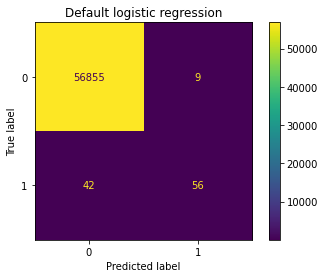

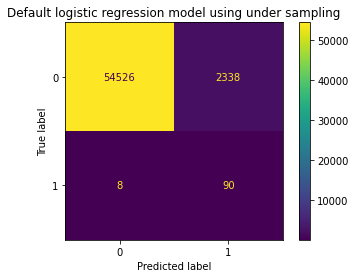

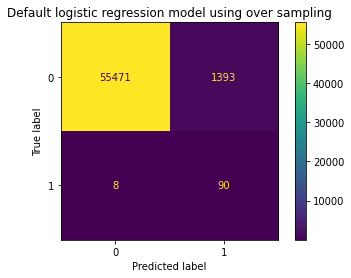

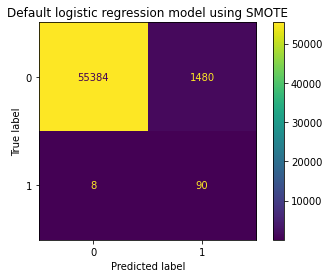

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

model1   = LogisticRegression().fit(X_dev,y_dev)
y_pred_1 = model1.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1)
plt.title('Default logistic regression')
plt.show()

model2  = LogisticRegression().fit(X_resampled,y_resampled)
y_pred_2 = model2.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2)
plt.title('Default logistic regression model using under sampling')
plt.show()

model3  = LogisticRegression().fit(X_resampled_,y_resampled_)
y_pred_3 = model3.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_3)
plt.title('Default logistic regression model using over sampling')
plt.show()

model4  = LogisticRegression().fit(X_dev_smote,y_dev_smote)
y_pred_4 = model4.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_4)
plt.title('Default logistic regression model using SMOTE')
plt.show()
# The default logistic regression model gives a high precision (0.86) and a low recall (0.57)
# Using undersampling, we notice that we get a much lower precision (0.037) and a much higher recall (0.92)
# Using oversampling,  we notice that we get a much lower precision (0.06) and a much higher recall (0.92)
# Using SMOTE,  we notice that we get a much lower precision (0.057) and a much higher recall (0.92)

**Q9. Plot the ROC for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

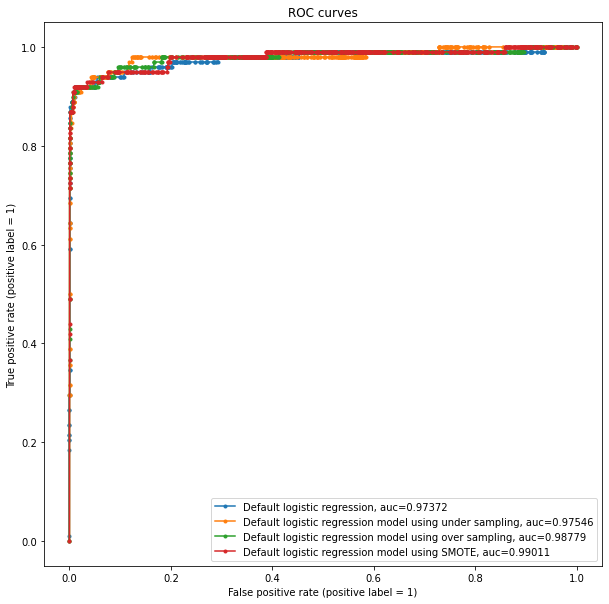

In [ ]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10,10))
y_pred_proba_1 = model1.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba_1[:,1])
plt.plot(fpr, tpr, marker='.', label="Default logistic regression, auc="+str(round(auc_1,5)))

y_pred_proba_2 = model2.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba_2[:,1])
plt.plot(fpr, tpr, marker='.', label="Default logistic regression model using under sampling, auc="+str(round(auc_2,5)))

y_pred_proba_3 = model3.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba_3[:,1])
plt.plot(fpr, tpr, marker='.', label="Default logistic regression model using over sampling, auc="+str(round(auc_3,5)))

y_pred_proba_4 = model4.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba_4[:,1])
plt.plot(fpr, tpr, marker='.', label="Default logistic regression model using SMOTE, auc="+str(round(auc_4,5)))


plt.xlabel('False positive rate (positive label = 1)')
plt.ylabel('True positive rate (positive label = 1)')
plt.title('ROC curves')
plt.legend()
plt.show()

# The results show that the different models have similar AUC values, even though we do notice an improvement between the default logistic model and RUS, ROS and the SMOTE techniques

**Q10. Plot the precision-recall curve for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

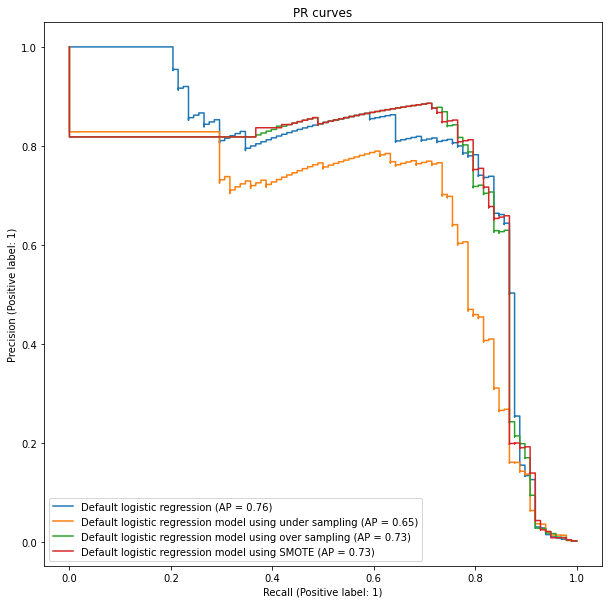

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

plt.figure(figsize=(10,10))
models = [model1,model2,model3,model4]
labels = ["Default logistic regression","Default logistic regression model using under sampling","Default logistic regression model using over sampling","Default logistic regression model using SMOTE"]
ax = plt.gca()
for i in range(len(models)):
     plot_precision_recall_curve(models[i],X_test,y_test,ax=ax,name=labels[i])
plt.title('PR curves')
plt.show()
# The results show that the RUS method has a worst avg precision than other methods
# THe results also show that the default logistic regression has the best avg precision


**Q11. Adding class weights to a logistic regression model. Print the AUC and average precision of 5-fold cross validation. Also, plot its confusion matrix on test set.**

The AUC is:  0.9795895039219964
THe average precision is: 0.7243987979812465


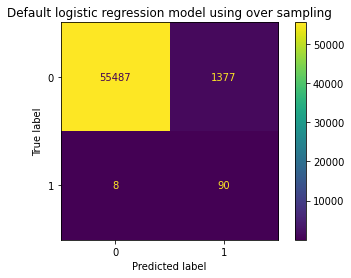

In [ ]:
scores = cross_validate(LogisticRegression(class_weight='balanced',random_state=42),X_dev,y_dev,cv=5,scoring=['roc_auc','average_precision'])
auc_5 = scores['test_roc_auc'].mean()
avg_precision_5 = scores['test_average_precision'].mean()

model5  = LogisticRegression(class_weight='balanced',random_state=42).fit(X_dev,y_dev)
y_pred_5 = model5.predict(X_test)
y_pred_proba_5 = model5.predict_proba(X_test)

auc_5 = metrics.roc_auc_score(y_test, y_pred_proba_5[:,1])
avg_precision_5 = average_precision_score(y_test, y_pred_proba_5[:,1])

print("The AUC is: ", auc_5)
print("THe average precision is:", avg_precision_5)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_5)
plt.title('Default logistic regression model using over sampling')
plt.show()

**Q12. Plot the ROC and the precision-recall curve for default Logistic without any sampling method and this balanced Logistic model in two single plots. Make sure to label the axes and legend. Comment on your result.**

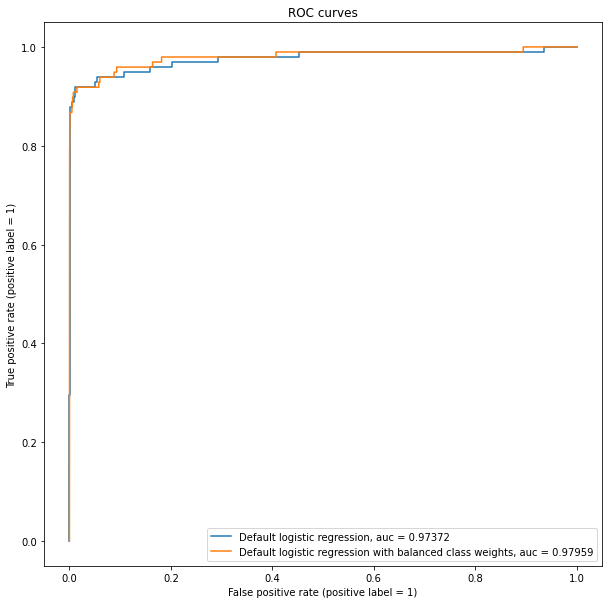

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


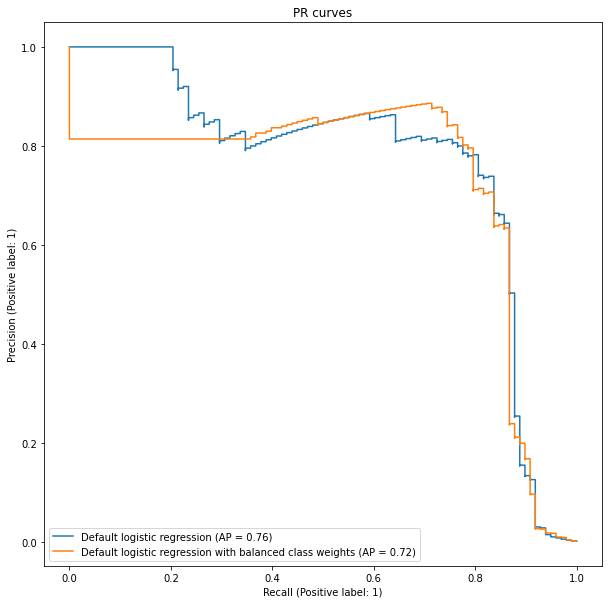

In [ ]:
plt.figure(figsize=(10,10))

fpr, tpr, thresh = roc_curve(y_test, y_pred_proba_1[:,1])
plt.plot(fpr,tpr,label="Default logistic regression, auc = "+str(round(auc_1,5)))

fpr, tpr, thresh = roc_curve(y_test, y_pred_proba_5[:,1])
plt.plot(fpr,tpr,label="Default logistic regression with balanced class weights, auc = "+str(round(auc_5,5)))

plt.xlabel('False positive rate (positive label = 1)')
plt.ylabel('True positive rate (positive label = 1)')
plt.title('ROC curves')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
models = [model1,model5]
labels = ["Default logistic regression","Default logistic regression with balanced class weights"]
ax = plt.gca()
for i in range(len(models)):
     plot_precision_recall_curve(models[i],X_test,y_test,ax=ax,name=labels[i])
plt.title('PR curves')
plt.show()

# While balancing the class weights does seem to improve the AUC, we do notice this comes at the expense of a lower avg precision

## Part 2: Unsupervised Learning

In this part, we will be applying unsupervised learning approaches to a problem in computational biology. Specifically, we will be analyzing single-cell genomic sequencing data. Single-cell genomics is a set of revolutionary new technologies which can profile the genome of a specimen (tissue, blood, etc.) at the resolution of individual cells. This increased granularity can help capture intercellular heterogeneity, key to better understanding and treating complex genetic diseases such as cancer and Alzheimer's. 

<img src="https://cdn.10xgenomics.com/image/upload/v1574196658/blog/singlecell-v.-bulk-image.png" width="800px"/>

<center>Source: 10xgenomics.com/blog/single-cell-rna-seq-an-introductory-overview-and-tools-for-getting-started</center>

A common challenge of genomic datasets is their high-dimensionality: a single observation (a cell, in the case of single-cell data) may have tens of thousands of gene expression features. Fortunately, biology offers a lot of structure - different genes work together in pathways and are co-regulated by gene regulatory networks. Unsupervised learning is widely used to discover this intrinsic structure and prepare the data for further analysis.

### Dataset: single-cell RNASeq of mouse brain cells

We will be working with a single-cell RNASeq dataset of mouse brain cells. In the following gene expression matrix, each row represents a cell and each column represents a gene. Each entry in the matrix is a normalized gene expression count - a higher value means that the gene is expressed more in that cell. The dataset has been pre-processed using various quality control and normalization methods for single-cell data. 

Data source is on Coursework.

In [ ]:
cell_gene_counts_df = pd.read_csv('mouse_brain_cells_gene_counts.csv', index_col='cell')
cell_gene_counts_df

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.08093,0.7856,1.334,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.567
A1.B003728.3_56_F.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.8350,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,-0.681
A1.MAA000560.3_10_M.1.1,-0.08093,0.6300,-0.576,-0.2727,-0.4153,-0.2084,-0.4692,-0.03146,-0.6035,1.253000,...,1.3150,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,2.072,-0.5654,-0.04385,1.260
A1.MAA000564.3_10_M.1.1,-0.08093,0.3809,1.782,-0.2727,-0.4153,1.0300,-0.4692,-0.03146,1.2640,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,2.3900,-0.553,0.1697,-0.04385,-0.681
A1.MAA000923.3_9_M.1.1,-0.08093,0.5654,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,2.3180,-0.5913,-0.553,-0.5654,-0.04385,-0.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2.MAA000902.3_11_M.1.1,14.98400,1.1550,-0.576,-0.2727,-0.4153,0.7530,-0.4692,-0.03146,-0.6035,-1.021000,...,1.4260,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.728
E2.MAA000926.3_9_M.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.4720,-0.4692,-0.03146,1.8120,1.079000,...,-0.7227,-0.2145,-0.1927,-0.4163,0.2422,-0.5913,-0.553,1.6060,-0.04385,-0.681
E2.MAA000932.3_11_M.1.1,-0.08093,0.5703,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-0.003473,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,2.074


Note the dimensionality - we have 1000 cells (observations) and 18,585 genes (features)!

We are also provided a metadata file with annotations for each cell (e.g. cell type, subtissue, mouse sex, etc.)

In [ ]:
cell_metadata_df = pd.read_csv('mouse_brain_cells_metadata.csv')
cell_metadata_df

,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
0,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
1,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
2,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
3,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
4,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0
...,...,...,...,...,...,...,...,...
995,E2.MAA000902.3_11_M.1.1,astrocyte,Striatum,M,3_11_M,MAA000902,3026,3134463.0
996,E2.MAA000926.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000926,3085,744301.0
997,E2.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932,2277,519257.0
998,E2.MAA000944.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000944,3234,1437895.0


Different cell types

In [ ]:
cell_metadata_df['cell_ontology_class'].value_counts()

oligodendrocyte                   385
endothelial cell                  264
astrocyte                         135
neuron                             94
brain pericyte                     58
oligodendrocyte precursor cell     54
Bergmann glial cell                10
Name: cell_ontology_class, dtype: int64

Different subtissue types (parts of the brain)

In [ ]:
cell_metadata_df['subtissue'].value_counts()

Cortex         364
Hippocampus    273
Striatum       220
Cerebellum     143
Name: subtissue, dtype: int64

Our goal in this exercise is to use dimensionality reduction and clustering to visualize and better understand the high-dimensional gene expression matrix. We will use the following pipeline, which is common in single-cell analysis:
1. Use PCA to project the gene expression matrix to a lower-dimensional linear subspace.
2. Cluster the data using K-means on the first 20 principal components.
3. Use t-SNE to project the first 20 principal components onto two dimensions. Visualize the points and color by their clusters from (2).

## 1 PCA

**Q1. Perform PCA and project the gene expression matrix onto its first 50 principal components. You may use `sklearn.decomposition.PCA`.**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_pca = pca.fit_transform(cell_gene_counts_df)
print(X_pca.shape)

(1000, 50)


**Q2. Plot the cumulative proportion of variance explained as a function of the number of principal components. How much of the total variance in the dataset is explained by the first 20 principal components?**

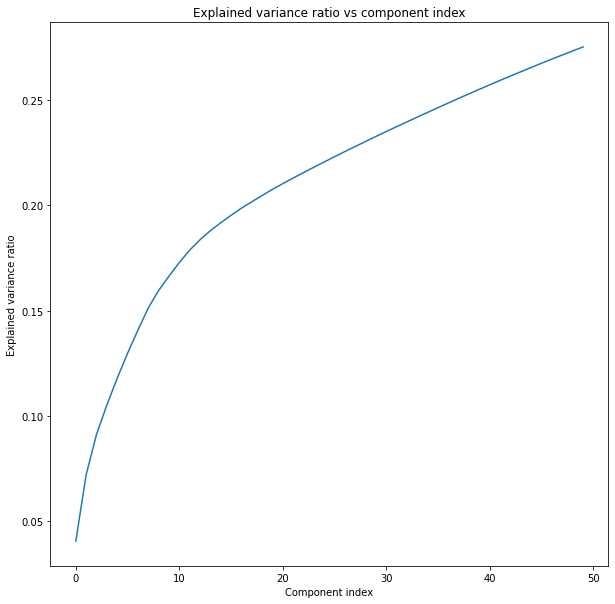

The first 20 components explain 20.76525881674333 % of the total variance in the dataset
The first 50 components explain 27.5309473005325 % of the total variance in the dataset


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component index')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio vs component index')
plt.show()

print("The first 20 components explain",100*sum(pca.explained_variance_ratio_[0:20]),"% of the total variance in the dataset")
print("The first 50 components explain",100*sum(pca.explained_variance_ratio_),"% of the total variance in the dataset")


**Q3. For the first principal component, report the top 10 loadings (weights) and their corresponding gene names.** In other words, which 10 genes are weighted the most in the first principal component?

In [ ]:
loadings = pd.DataFrame(pca.components_.T[:,:2],columns=['PC1','PC2'],index=cell_gene_counts_df.columns)
display(loadings)

loading = pd.DataFrame(pca.components_.T[:,:1],columns=['PC1'],index=cell_gene_counts_df.columns)
display(loading)
print("The top 10 loading (weights) and their corresponding gene names are:")
display(loading['PC1'].nlargest(n=10))


,PC1,PC2
0610005C13Rik,8.366413e-04,-1.160352e-03
0610007C21Rik,6.774360e-03,-6.887623e-03
0610007L01Rik,3.399618e-03,5.563988e-03
0610007N19Rik,-2.281543e-03,7.633379e-03
0610007P08Rik,5.332041e-03,-2.156573e-03
...,...,...
Zyx,7.855487e-04,1.613853e-03
Zzef1,1.117847e-02,3.243034e-03
Zzz3,6.543945e-03,-5.798519e-04
a,6.621512e-36,1.924525e-35


,PC1
0610005C13Rik,8.366413e-04
0610007C21Rik,6.774360e-03
0610007L01Rik,3.399618e-03
0610007N19Rik,-2.281543e-03
0610007P08Rik,5.332041e-03
...,...
Zyx,7.855487e-04
Zzef1,1.117847e-02
Zzz3,6.543945e-03
a,6.621512e-36


The top 10 loading (weights) and their corresponding gene names are:


Nsg2        0.026673
St8sia3     0.026595
Ptpn5       0.026588
Kcnj4       0.026539
Rasgef1a    0.026347
Camkv       0.026221
Hpca        0.026173
Cpne5       0.026022
Nrsn2       0.025979
Erc2        0.025853
Name: PC1, dtype: float64

**Q4. Plot the projection of the data onto the first two principal components using a scatter plot.**

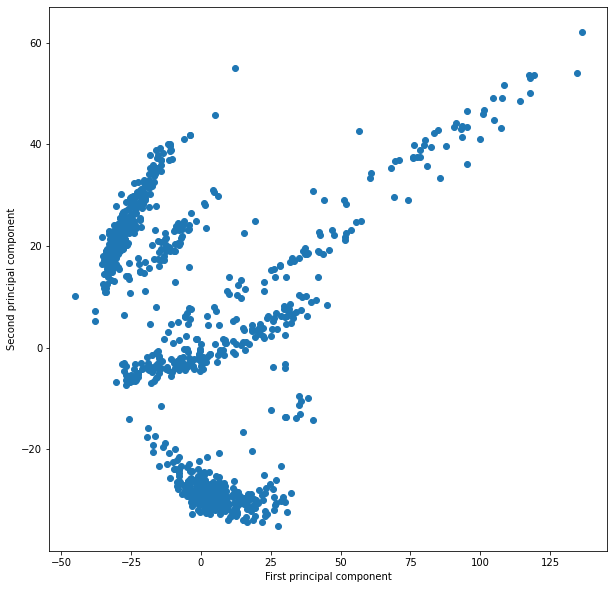

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

**Q5. Now, use a small multiple of four scatter plots to make the same plot as above, but colored by four annotations in the metadata: cell_ontology_class, subtissue, mouse.sex, mouse.id. Include a legend for the labels.** For example, one of the plots should have points projected onto PC 1 and PC 2, colored by their cell_ontology_class.

(1000, 50)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,cell_ontology_class,subtissue,mouse.sex,mouse.id
0,15.353967,22.551441,28.909568,18.160747,-63.669868,63.397365,22.120391,193.168078,5.079538,-12.084529,...,8.940424,1.193043,-13.857491,-4.136790,4.338548,6.472519,astrocyte,Striatum,F,3_38_F
1,-19.092789,-3.011189,37.073015,-7.781964,-0.324304,-5.520998,1.450258,-0.053578,-2.177460,3.883149,...,-0.520969,1.158872,-1.101235,0.679775,0.597201,-0.690451,astrocyte,Striatum,F,3_56_F
2,1.624026,-26.093832,-8.735882,1.431624,3.908803,-0.872088,-2.047057,2.420196,3.514789,3.970501,...,1.515602,-0.645285,-1.347725,0.378542,0.872869,-0.766571,oligodendrocyte,Cortex,M,3_10_M
3,-15.469770,37.906454,-37.408305,5.952023,-10.229881,4.293255,15.286238,-4.262457,-6.747909,6.367113,...,-0.863288,-0.881384,-6.863632,2.933418,-5.520346,-0.881531,endothelial cell,Striatum,M,3_10_M
4,-15.223271,-2.999145,38.531674,-6.379690,-6.113619,-4.637017,5.044908,-2.089752,-6.841584,3.252492,...,-1.198946,1.945516,1.404167,0.700025,-1.037121,-1.049780,astrocyte,Hippocampus,M,3_9_M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-3.155956,-3.599854,36.290781,-5.177450,-19.399649,0.435053,11.439439,-9.045934,-15.710148,9.538517,...,-1.469688,1.212500,0.167936,-0.659675,-1.232779,3.101339,astrocyte,Striatum,M,3_11_M
996,-1.474810,-25.927919,-4.133709,0.153574,6.328285,-2.617473,-2.451733,3.187181,1.757354,-3.302633,...,-0.475186,0.099014,2.143594,0.705748,1.223871,0.784005,oligodendrocyte,Cortex,M,3_9_M
997,-28.401428,19.681180,-7.704601,-1.473940,6.044442,-5.930667,3.987713,1.741061,-1.530289,-4.954190,...,-1.161712,3.002194,-1.852733,4.714177,-1.574095,2.147166,endothelial cell,Hippocampus,M,3_11_M
998,4.029614,-30.038009,-7.426854,1.246195,3.455531,-0.855074,-1.850934,1.335377,-1.726047,-3.373319,...,0.645080,0.257949,0.135163,-1.419967,0.252577,0.766517,oligodendrocyte,Cortex,M,3_9_M


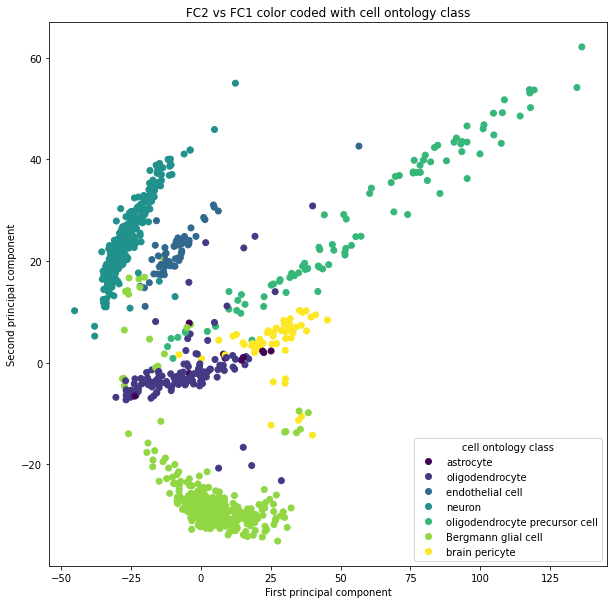

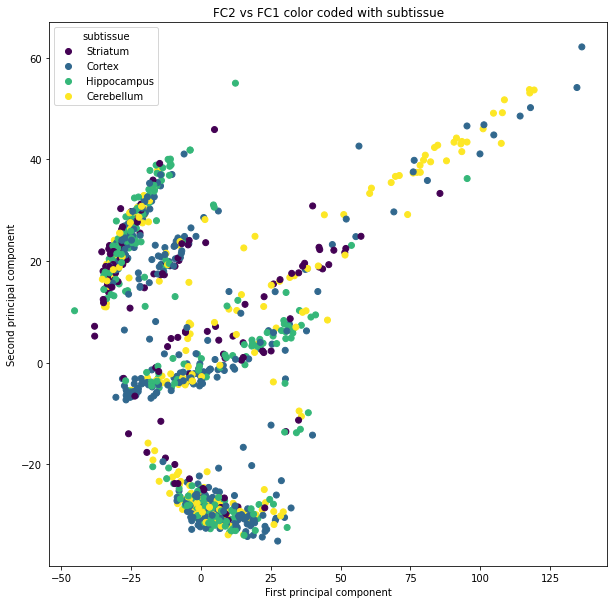

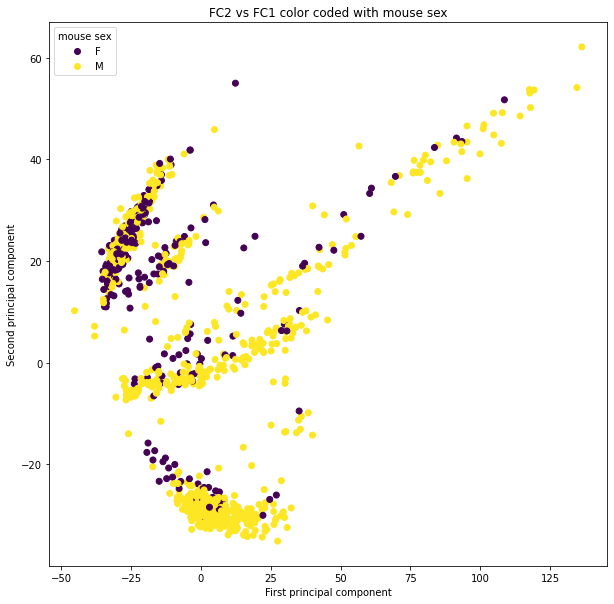

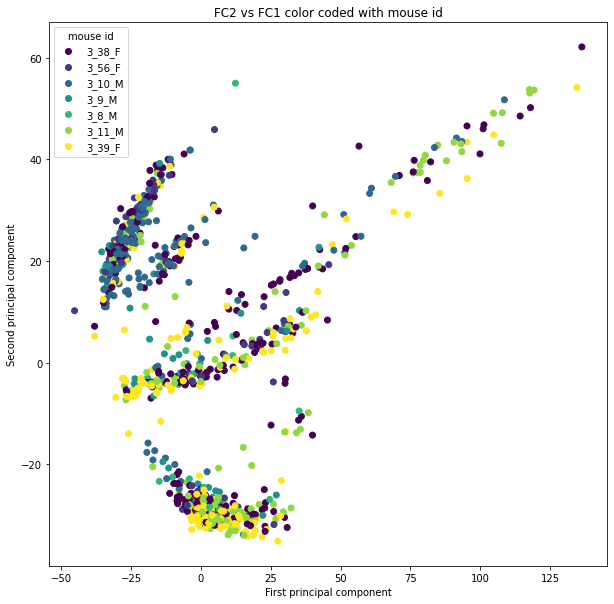

In [ ]:
display(X_pca.shape)
X_pca = pd.DataFrame(X_pca)
X_pca['cell_ontology_class'] = cell_metadata_df['cell_ontology_class']
X_pca['subtissue'] = cell_metadata_df['subtissue']
X_pca['mouse.sex'] = cell_metadata_df['mouse.sex']
X_pca['mouse.id'] = cell_metadata_df['mouse.id']

display(X_pca)

plt.figure(figsize=(10,10))
sp_names = X_pca.cell_ontology_class.unique().tolist()
scatter = plt.scatter(X_pca[0],X_pca[1],c=X_pca.cell_ontology_class.astype('category').cat.codes)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title('FC2 vs FC1 color coded with cell ontology class')
plt.legend(handles=scatter.legend_elements()[0],labels=sp_names,title="cell ontology class")
plt.show()

plt.figure(figsize=(10,10))
sp_names = X_pca.subtissue.unique().tolist()
scatter = plt.scatter(X_pca[0],X_pca[1],c=X_pca.subtissue.astype('category').cat.codes)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title('FC2 vs FC1 color coded with subtissue')
plt.legend(handles=scatter.legend_elements()[0],labels=sp_names,title="subtissue")
plt.show()

plt.figure(figsize=(10,10))
sp_names = X_pca['mouse.sex'].unique().tolist()
scatter = plt.scatter(X_pca[0],X_pca[1],c=X_pca['mouse.sex'].astype('category').cat.codes)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title('FC2 vs FC1 color coded with mouse sex')
plt.legend(handles=scatter.legend_elements()[0],labels=sp_names,title="mouse sex")
plt.show()

plt.figure(figsize=(10,10))
sp_names = X_pca['mouse.id'].unique().tolist()
scatter = plt.scatter(X_pca[0],X_pca[1],c=X_pca['mouse.id'].astype('category').cat.codes)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title('FC2 vs FC1 color coded with mouse id')
plt.legend(handles=scatter.legend_elements()[0],labels=sp_names,title="mouse id")
plt.show()

**Q6. Based on the plots above, the first two principal components correspond to which aspect of the cells? What is the intrinsic dimension that they are describing?**

In [ ]:
# The two principal components correspond to the cell ontology class aspect of the cells

## 2 K-means

While the annotations provide high-level information on cell type (e.g. cell_ontology_class has 7 categories), we may also be interested in finding more granular subtypes of cells. To achieve this, we will use K-means clustering to find a large number of clusters in the gene expression dataset. Note that the original gene expression matrix had over 18,000 noisy features, which is not ideal for clustering. So, we will perform K-means clustering on the first 20 principal components of the dataset.

**Q7. Implement a `kmeans` function which takes in a dataset `X` and a number of clusters `k`, and returns the cluster assignment for each point in `X`. You may NOT use sklearn for this implementation. Use lecture 6, slide 14 as a reference.**

In [ ]:
from scipy.spatial import distance
from scipy.spatial.distance import cdist 

def kmeans(X, k, iters=10):
    '''Groups the points in X into k clusters using the K-means algorithm.

    Parameters
    ----------
    X : (m x n) data matrix
    k: number of clusters
    iters: number of iterations to run k-means loop

    Returns
    -------
    y: (m x 1) cluster assignment for each point in X
    '''
    # Initialize centroid randomly
    indexes = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indexes]
    y = np.zeros((X.shape[0],)) 
  
    while iters!=0:
        for i in range(X.shape[0]):
            row = X[i]
            min_dis = float('inf')

            for idx, centroid in enumerate(centroids):
                d = np.sqrt((centroid[0]-row[0])**2 + (centroid[1]-row[1])**2)
                # Save nearest centroid
                if min_dis > d:
                    min_dis = d
                    y[i] = idx
        new_centroids = pd.DataFrame(X).groupby(by=y).mean().values        
        centroids = new_centroids
            
        iters = iters-1
    return y

Before applying K-means on the gene expression data, we will test it on the following synthetic dataset to make sure that the implementation is working.

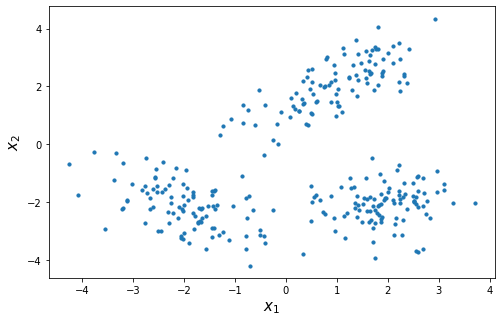

In [ ]:
np.random.seed(0)
x_1 = np.random.multivariate_normal(mean=[1, 2], cov=np.array([[0.8, 0.6], [0.6, 0.8]]), size=100)
x_2 = np.random.multivariate_normal(mean=[-2, -2], cov=np.array([[0.8, -0.4], [-0.4, 0.8]]), size=100)
x_3 = np.random.multivariate_normal(mean=[2, -2], cov=np.array([[0.4, 0], [0, 0.4]]), size=100)
X = np.vstack([x_1, x_2, x_3])

plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.show()

**Q8. Apply K-means with k=3 to the synthetic dataset above. Plot the points colored by their K-means cluster assignments to verify that your implementation is working.**

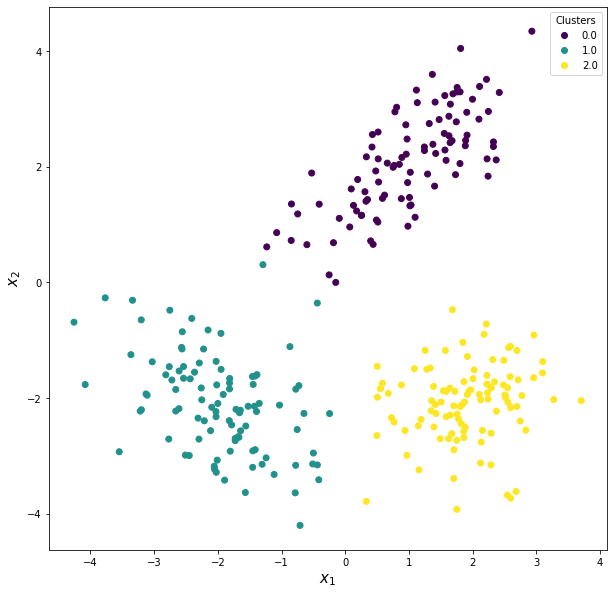

In [ ]:
res = kmeans(X,3)
sp_names = np.unique(res).tolist()

plt.figure(figsize=(10,10))
scatter = plt.scatter(X[:,0],X[:,1],c=res)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.legend(handles=scatter.legend_elements()[0],labels=sp_names,title="Clusters")
plt.show()

**Q9. Use K-means with k=20 to cluster the first 20 principal components of the gene expression data.**

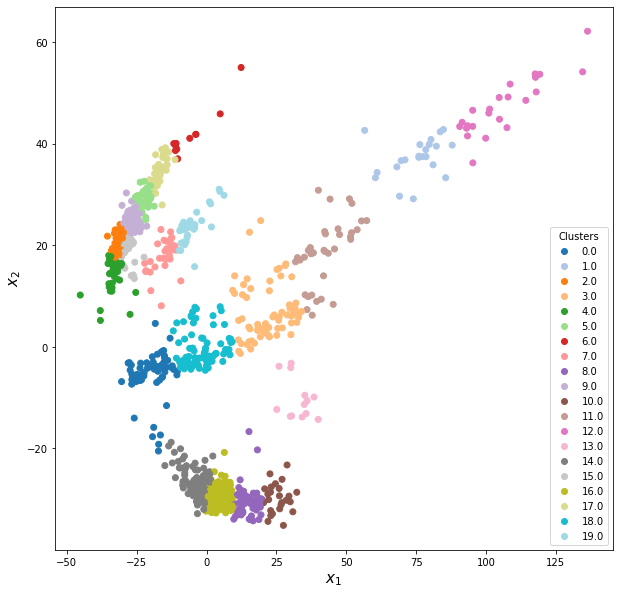

In [ ]:
X_pca = X_pca.to_numpy()
res  = kmeans(X_pca[:,:20],20)
sp_names = np.unique(res).tolist()

plt.figure(figsize=(10,10))
scatter = plt.scatter(X_pca[:,0],X_pca[:,1],c=res, cmap='tab20')
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.legend(handles=scatter.legend_elements(prop='colors', num=None)[0],labels=sp_names,title="Clusters")
plt.show()

## 3 t-SNE

In this final section, we will visualize the data again using t-SNE - a non-linear dimensionality reduction algorithm. You can learn more about t-SNE in this interactive tutorial: https://distill.pub/2016/misread-tsne/.

**Q10. Use t-SNE to reduce the first 20 principal components of the gene expression dataset to two dimensions. You may use `sklearn.manifold.TSNE`.** Note that it is recommended to first perform PCA before applying t-SNE to suppress noise and speed up computation.

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2)
X_embedded = model.fit_transform(X_pca[:,:20]) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


**Q11. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions.**

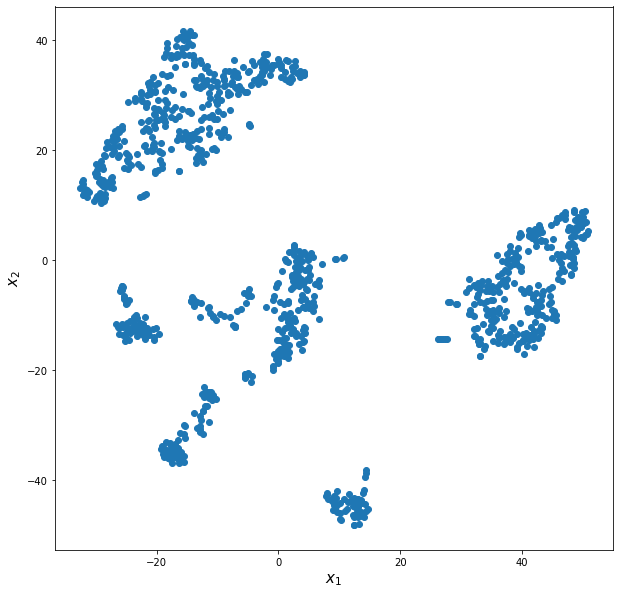

In [ ]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1])
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.show()

**Q12. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions, with points colored by their cluster assignments from part 2.**

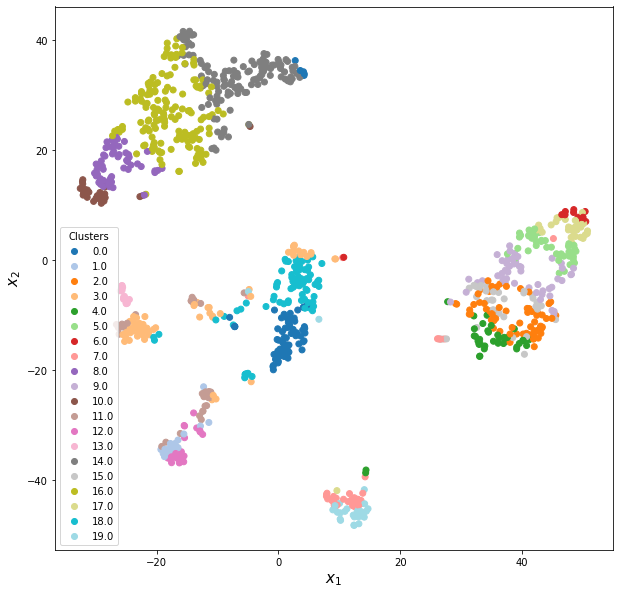

In [ ]:
plt.figure(figsize=(10,10))

scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1],c=res, cmap='tab20')
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.legend(handles=scatter.legend_elements(prop='colors', num=None)[0],labels=sp_names,title="Clusters")
plt.show()

**Q13. Why is there overlap between points in different clusters in the t-SNE plot above?**

In [ ]:
# The overlap between points in different clusters is controlled by the perplexity parameter in the t-SNE plot. 
# By default, the perplexity parameter is set to 30.

These 20 clusters may correspond to various cell subtypes or cell states. They can be further investigated and mapped to known cell types based on their gene expressions (e.g. using the K-means cluster centers). The clusters may also be used in downstream analysis. For instance, we can monitor how the clusters evolve and interact with each other over time in response to a treatment.